# ✔️ Problem Formulation:
**The problem: ❎**

Anticancer activity prediction, where each chemical compound is represented as a graph, with atoms representing nodes and bonds as edges. A chemical compound is positive against non-small cell lung cancer, or negative otherwise. 

**What is the input? ⏩**

there are a train set and test set, 2 input features: nodes and edges between these nodes.

**What is the output? ⏪**

Predict chemical compound is effective or Not.

**What data mining function is required? 🤔**

-Classification.
-predection.
-tokenization.

**What could be the challenges? ⛏**


*   the train and test data are SDF file.

*   Find the best way to train this data and get the best accuracy.

*   Handle with data imbalance.





**What is the impact? 😀**

The resolution of this medical issue will advance medicine, particularly in the treatment of lung cancer, by leading medical professionals to seek out the most effective treatments.

**What is an ideal solution?**✊

The Sixth trail when using GGNN after Resampleing.  
GGNN can achieve better performance and accuracy than other GNN models or traditional machine learning methods for anti-cancer activity prediction.
This Trail Get Score on Kaggle (0.85219)



# Experimental protocol 💻
-Read SDF format data (structured-data format)

-read dataset from SDF file

-Spilt train set to train validation set

-Visualizing/Inspecting a Sample
- Preprocessing:
*   Toknization.

-building models (the First five trail) without UP sampling We using:


1.   GAN
2.   RGCN
3.   RGAT
4.   RGIN
5.   GGNN
6.   Using Conv2d layer. (Multi-objective learning (multi-task))
7.   Transfer learning (VGG model) (Multi-modality learning with Multi-objective learning)
-Model Training
-Predition
-Create Submit file and check the score of each model on kaggle.

## Read SDF format data (structured-data format) 🔀

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

#Read the train and test set

In [ ]:
#read the traing data 
train = read_sdf('/content/train.sdf')
#read the test data 
test = read_sdf('/content/test_x.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

#Spilt train set to train validation set

In [ ]:
#Splitting traing data 
from sklearn.model_selection import train_test_split
X, Y = train_test_split(train, test_size=0.15,)
     

In [ ]:
print(X[1])


(['O', 'O', 'O', 'O', 'N', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  4],
       [ 1,  4],
       [ 2,  6],
       [ 3,  6],
       [ 4,  8],
       [ 5,  7],
       [ 5,  9],
       [ 6, 10],
       [ 7, 16],
       [ 8,  9],
       [ 8, 11],
       [ 9, 14],
       [10, 11],
       [10, 15],
       [12, 13],
       [12, 17],
       [12, 19],
       [13, 18],
       [13, 20],
       [14, 15],
       [16, 18],
       [16, 21],
       [17, 22],
       [17, 24],
       [19, 23],
       [20, 23],
       [21, 22]]), 0)


## Visualizing/Inspecting a Sample 🖼

In [ ]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [ ]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

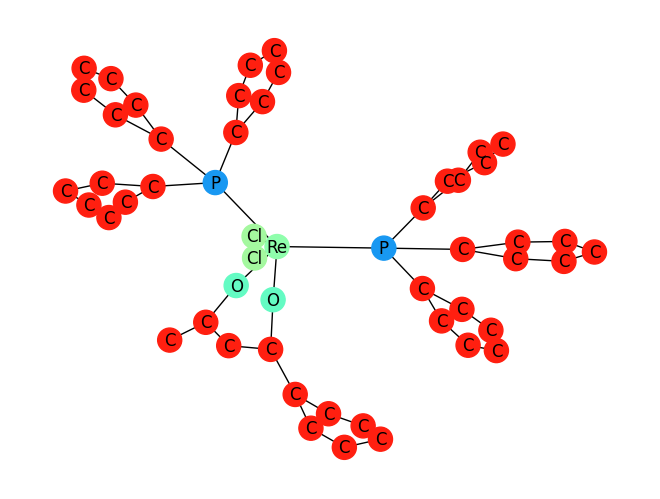

In [ ]:
plt.clf()
visualize(X[20])

#Preprocessing:

# Toknization

Tokenization is an important step in text preprocessing that can help facilitate downstream NLP tasks.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in X]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(X, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[4 2 2 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 2 2 2 2 3
 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 5 2 2 3 3 3 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 4 3 3 3 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0  23]
 [  1   9]
 [  2  13]
 [  3   4]
 [  3   7]
 [  3   9]
 [  4   8]
 [  5   7]
 [  5  10]
 [  6  12]
 [  6  13]
 [  7  14]
 [  8  11]
 [  8  13]
 [  9  10]
 [ 10  15]
 [ 11  12]
 [ 11  16]
 [ 12  17]
 [ 14  19]
 [ 14  20]
 [ 15  18]
 [ 16  21]
 [ 17  22]
 [ 18  23]
 [ 18  24]
 [ 19  25]
 [ 20  26]
 [ 21  22]
 [ 23  28]
 [ 24  29]
 [ 25  27]
 [ 26  27]
 [ 28  30]
 [ 29  30]
 [ 31  34]
 [ 31  35]
 [ 31  38]
 [ 31  53]
 [ 32  39]
 [ 32  45]
 [ 33  44]
 [ 36  37]
 [ 36  40]
 [ 37  52]
 [ 39  40]
 [ 39  41]
 [ 40  42]
 [ 41  44]
 [ 41  46]
 [ 42  43]
 [ 42  47]
 [ 43  44]
 [ 43  49]
 [ 45  48]
 [ 45  54]
 [ 45  55]
 [ 46  48]
 [ 47  50]
 [ 49  51]
 [ 50  51]
 [ 52  56]
 [ 52  57]
 [ 53  58]
 [ 53  59]
 [ 56  58]
 [ 57  59]

# The First Trail
#GNN
GNNs are particularly useful in scenarios where the data is structured as a graph, which consists of nodes and edges that connect them. GNNs can learn to effectively capture information from the graph structure, such as local and global relationships between nodes, and use this information to make predictions or perform other tasks.



GNNs can be a powerful tool for anti-cancer activity prediction, leveraging the structure of molecular and drug interaction networks to identify potential therapeutics.
we will check that:



`I have no expectation how it will perform`


In [ ]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 16.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
#Import the necessary modules
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

#Define the input for the node features (a batch of sequences of tokens)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
# Compute the maximum graph index in the node2graph array
num_graph = tf.reduce_max(node2graph)+1

# Create a GNNInput object that contains the node features, adjacency lists,
# node to graph map, and number of graphs
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


# Get the default hyperparameters for the GNN model and set the hidden dimension to 32
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32

# Create a GNN layer with the given parameters
gnn_layer = GNN(params)
# Apply the GNN layer to the input and get the output node representations
gnn_out = gnn_layer(gnn_input)

# Print the shape and values of gnn_out
print('gnn_out', gnn_out)

# Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)

# Print the shape and values of avg
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 5 epochs using a custom data generator and batch size of 16
import math

batch_size = 16
num_batchs = math.ceil(len(X) / batch_size)
num_batchs_validation = math.ceil(len(Y) / batch_size)

model.fit(
    gen_batch(
        X, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=5,
    validation_data=gen_batch(
        Y, batch_size=16, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/5
1330/1330 [==============================] - 48s 32ms/step - loss: 0.2286 - auc: 0.5057 - val_loss: 0.2021 - val_auc: 0.6234
Epoch 2/5
1330/1330 [==============================] - 24s 18ms/step - loss: 0.1931 - auc: 0.6186 - val_loss: 0.1923 - val_auc: 0.6978
Epoch 3/5
1330/1330 [==============================] - 25s 19ms/step - loss: 0.1895 - auc: 0.6439 - val_loss: 0.1912 - val_auc: 0.7121
Epoch 4/5
1330/1330 [==============================] - 28s 21ms/step - loss: 0.1878 - auc: 0.6519 - val_loss: 0.1872 - val_auc: 0.7148
Epoch 5/5
1330/1330 [==============================] - 41s 31ms/step - loss: 0.1867 - auc: 0.6603 - val_loss: 0.1903 - val_auc: 0.7261


## Predition

We can use the model to predict the testing samples.

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 16 and not shuffled
y_pred = model.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 6s 7ms/step


In [ ]:
len(y_pred)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('sample_submission.csv')

This trail get score 0.71461 on Kaggle.
`it's not bad there is no overfitting or underfitting.`

#The Secound Trail
#RGCN

RGCN, or Relational Graph Convolution Network , is a type of Graph Neural Network (GNN) that can be used for modeling relational data. Specifically, RGCNs can be used for link prediction and recommendation systems, where the goal is to predict the presence or absence of a connection between two entities in a graph.

may require experimentation and testing to determine the most effective approach. 

RGCNs can be used to predict the efficacy of potential drugs based on their molecular structures and relationships with biological targets. By analyzing the graph structure of the relationship network between drugs, molecular structures, and biological targets, RGCNs can learn to extract features that are important in predicting the anti-cancer activity of compounds.

RGCNs can provide a powerful tool for anti-cancer activity prediction by leveraging the structure of relational data and identifying key features and relationships that are important in predicting cancer outcomes, an RGCN model could be a suitable choice


`I expect the performance will be better than the previous trail.`


In [ ]:
#Import the necessary modules

import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

#Define the input for the node features (a batch of sequences of tokens)
data = Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge_index = Input(batch_shape=(None, 2),  dtype=tf.int32)
node2graph = Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Define the RGCN layer
rgcn_input = GNNInput( 
    node_features=embeded,
    adjacency_lists=(edge_index,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph, 
)



#Get the default hyperparameters for the GNN model and set the hidden dimension to 64

params1 = GNN.get_default_hyperparameters()
params1["hidden_dim"] = 64
params1["num_aggr_MLP_HIDDEN_LAYERS"] = 32
params1['message_calculation_class']= 'RGCN'

#Create a RGCN layer with the given parameters

rgcn_layer = GNN(params1)

#Apply the RGCN layer to the input and get the output node representations
rgcn_out = rgcn_layer(rgcn_input)

#Print the shape and values of rgcn_out
print('rgcn_out', rgcn_out)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=rgcn_out,
    segment_ids=node2graph
)

#Print the shape and values of avg
print('mean:', avg)


#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred1 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred1)

#Define the model with inputs and outputs
model1 = Model(
    inputs={
        'data': data,
        'edges': edge_index,
        'node2grah': node2graph,
    },
    outputs=pred1
)
model1.summary()


rgcn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []       

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model1.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 15 epochs using a custom data generator and batch size of 32

import math

batch_size = 32
num_batchs = math.ceil(len(X) / batch_size)
num_batchs_validation = math.ceil(len(Y) / batch_size)

model1.fit(
    gen_batch(
        X, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        Y, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/15
665/665 [==============================] - 37s 56ms/step - loss: 0.1956 - auc: 0.6096 - val_loss: 0.2016 - val_auc: 0.6532
Epoch 2/15
665/665 [==============================] - 38s 57ms/step - loss: 0.1893 - auc: 0.6500 - val_loss: 0.1922 - val_auc: 0.6962
Epoch 3/15
665/665 [==============================] - 37s 55ms/step - loss: 0.1856 - auc: 0.6704 - val_loss: 0.1871 - val_auc: 0.7154
Epoch 4/15
665/665 [==============================] - 36s 54ms/step - loss: 0.1846 - auc: 0.6773 - val_loss: 0.1827 - val_auc: 0.7275
Epoch 5/15
665/665 [==============================] - 37s 55ms/step - loss: 0.1818 - auc: 0.6916 - val_loss: 0.2109 - val_auc: 0.7065
Epoch 6/15
665/665 [==============================] - 37s 55ms/step - loss: 0.1796 - auc: 0.7016 - val_loss: 0.1780 - val_auc: 0.7355
Epoch 7/15
665/665 [==============================] - 36s 54ms/step - loss: 0.1780 - auc: 0.7147 - val_loss: 0.1807 - val_auc: 0.7383
Epoch 8/15
665/665 [==============================] - 36s 55ms

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 16 and not shuffled
y_pred1 = model1.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred1 = np.reshape(y_pred1, -1)

771/771 [==============================] - 9s 11ms/step


In [ ]:
len(y_pred1)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred1})
submission.index.name = 'id'
submission.to_csv('sample_submission1.csv')

This trail get score 0.76522 on Kaggle 

`it's better than the previous trail and there is no overfitting or underfitting.`

# The Third trail
# RGAT


*   The Relational Graph Attention Network (RGAT) is a type of graph neural network (GNN) that is used for processing relationships between entities in a graph. 

*   RGATs are specifically designed to address the limitations of previous GNNs, such as the Graph Convolutional Network (GCN), which only consider a fixed edge weight for all nodes. RGATs model the relationships between pairs of nodes as edge weights and then use attention mechanisms to weigh these relationships, allowing the network to learn which relationships are most important for a given task.

*   The main advantages of using RGAT over other GNNs include:

      * Improved ability to capture complex dependencies in the graph

      * Improved interpretability of the learned representation

      * Improved performance on tasks that require reasoning about relationships between nodes
*   Relational Graph Attention Network (RGAT) can be used for anti-cancer activity prediction by modeling relationships between entities such as molecular structures and biological activity using a graph. The RGAT architecture can learn to weigh relationships between entities, allowing it to capture complex dependencies in the graph and identify the most important relationships for predicting anti-cancer activity.
*   RGAT could be a powerful tool for anti-cancer activity prediction, especially when the dependencies between molecular structures are complex and difficult to capture with traditional machine learning techniques.











`I expect the performance will be better than the previous trails.`


In [ ]:
#Define the input for the node features (a batch of sequences of tokens)
data = Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge_index = Input(batch_shape=(None, 2),  dtype=tf.int32)
node2graph = Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Define the RGAT layer
rgat_input = GNNInput( 
    node_features=embeded,
    adjacency_lists=(edge_index,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph, 
)


#Get the default hyperparameters for the GNN model and set the hidden dimension to 64

params2 = GNN.get_default_hyperparameters()
params2["hidden_dim"] = 64
#Set the number of hidden layers for the aggregation MLP to 32
params2["num_aggr_MLP_HIDDEN_LAYERS"] = 32
#Set the message calculation class to RGAT (Relational Graph Attention Network)
params2['message_calculation_class']= 'RGAT'
#Set the number of attention heads to 4
params2['num_heads']= 4
#Create a GNN layer with the given parameters
rgat_layer = GNN(params2)
#Apply the GNN layer to the input and get the output node representations
rgat_out = rgat_layer(rgat_input)
#Print the shape and values of rgat_out
print('rgat_out', rgat_out)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=rgat_out,
    segment_ids=node2graph
)

#Print the shape and values of avg
print('mean:', avg)

#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred2 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred2)

#Define the model with inputs and outputs
model2 = Model(
    inputs={
        'data': data,
        'edges': edge_index,
        'node2grah': node2graph,
    },
    outputs=pred2
)
model2.summary()


rgan_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []       

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model2.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 30 epochs using a custom data generator and batch size of 32

import math

batch_size = 32
num_batchs = math.ceil(len(X) / batch_size)
num_batchs_validation = math.ceil(len(Y) / batch_size)

history = model2.fit(
    gen_batch(
        X, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        Y, batch_size=50, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30
665/665 [==============================] - 53s 80ms/step - loss: 0.1692 - auc: 0.7557 - val_loss: 0.1782 - val_auc: 0.7706
Epoch 2/30
665/665 [==============================] - 53s 80ms/step - loss: 0.1706 - auc: 0.7538 - val_loss: 0.1778 - val_auc: 0.7624
Epoch 3/30
665/665 [==============================] - 53s 80ms/step - loss: 0.1688 - auc: 0.7656 - val_loss: 0.1654 - val_auc: 0.7716
Epoch 4/30
665/665 [==============================] - 52s 79ms/step - loss: 0.1707 - auc: 0.7505 - val_loss: 0.1806 - val_auc: 0.7411
Epoch 5/30
665/665 [==============================] - 53s 80ms/step - loss: 0.1693 - auc: 0.7539 - val_loss: 0.1749 - val_auc: 0.7639
Epoch 6/30
665/665 [==============================] - 53s 80ms/step - loss: 0.1702 - auc: 0.7476 - val_loss: 0.2016 - val_auc: 0.7356
Epoch 7/30
665/665 [==============================] - 53s 80ms/step - loss: 0.1700 - auc: 0.7509 - val_loss: 0.1689 - val_auc: 0.7510
Epoch 8/30
665/665 [==============================] - 53s 79ms

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 32 and not shuffled
y_pred2 = model2.predict(
    gen_batch(test, batch_size=32, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred2 = np.reshape(y_pred2, -1)

386/386 [==============================] - 9s 21ms/step


In [ ]:
len(y_pred2)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred2})
submission.index.name = 'id'
submission.to_csv('sample_submission2.csv')

This trail get score 0.77885 on Kaggle 

`it's better than the previous trail and there is no overfitting or underfitting.`

#The Fourth trail
#RGIN

* a Relational Graph Isomorphism Network (RGIN) is a type of Graph Neural Network (GNN) that has a high discriminative power and can capture complex structural patterns in graphs. It is based on the idea of the Weisfeiler-Lehman test, which is a method to check if two graphs are isomorphic, i.e., have the same structure. A RGIN uses a simple aggregator function that updates the node features by adding the sum of the neighbor features and applying a nonlinear transformation. This way, it can preserve the node identity and distinguish between different graph structures. This way, it can preserve the node identity and distinguish between different graph structures.
* We set the message calculation class to RGIN when we want to use this powerful GNN architecture for graph representation learning tasks, such as node classification, graph classification, or link prediction. RGIN can learn more expressive and informative node embeddings than other GNN models, such as GCN or GraphSAGE, which use more complex aggregators that may lose some structural information. RGIN can also handle graphs with different types of edges or relations, by using different weight matrices for each edge type.
* RGIN can learn the structural and relational features of ACPs and their interactions with cancer cell membranes, and predict their anti-cancer activity based on their node embeddings. RGIN can also provide interpretable explanations for the predictions by highlighting the important nodes and edges that contribute to the anti-cancer activity of ACPs. 




`I have no expectations let's see what happens`

In [ ]:
#Define the input for the node features (a batch of sequences of tokens)
data = Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge_index = Input(batch_shape=(None, 2),  dtype=tf.int32)
node2graph = Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Define the RGIN layer
rgin_input = GNNInput( 
    node_features=embeded,
    adjacency_lists=(edge_index,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph, 
)

#Get the default hyperparameters for the GNN model and set the hidden dimension to 64
params3 = GNN.get_default_hyperparameters()
params3["hidden_dim"] = 64
#Set the number of hidden layers for the aggregation MLP to 64
params3["num_aggr_MLP_hidden_layers"] = 64
#Set the message calculation class to RGIN (Relational Graph Isomorphism Network)
params3['message_calculation_class']= 'RGIN'

#Create a GNN layer with the given parameters
rgin_layer = GNN(params3)

#Apply the GNN layer to the input and get the output node representations
rgin_out = rgin_layer(rgin_input)

#Print the shape and values of rgin_out
print('rgin_out', rgin_out)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=rgin_out,
    segment_ids=node2graph
)

#Print the shape and values of avg
print('mean:', avg)


#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred3 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred3)

#Define the model with inputs and outputs
model3 = Model(
    inputs={
        'data': data,
        'edges': edge_index,
        'node2grah': node2graph,
    },
    outputs=pred3
)
model3.summary()


rgin_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []       

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model3.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 30 epochs using a custom data generator and batch size of 32

import math

batch_size = 32
num_batchs = math.ceil(len(X) / batch_size)
num_batchs_validation = math.ceil(len(Y) / batch_size)

history = model3.fit(
    gen_batch(
        X, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        Y, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30
665/665 [==============================] - 39s 59ms/step - loss: 0.5582 - auc: 0.5033 - val_loss: 0.4519 - val_auc: 0.5000
Epoch 2/30
665/665 [==============================] - 34s 51ms/step - loss: 0.3652 - auc: 0.5060 - val_loss: 0.3123 - val_auc: 0.5000
Epoch 3/30
665/665 [==============================] - 31s 47ms/step - loss: 0.2576 - auc: 0.5027 - val_loss: 0.2443 - val_auc: 0.5000
Epoch 4/30
665/665 [==============================] - 32s 49ms/step - loss: 0.2090 - auc: 0.5109 - val_loss: 0.2228 - val_auc: 0.5000
Epoch 5/30
665/665 [==============================] - 32s 47ms/step - loss: 0.1941 - auc: 0.4825 - val_loss: 0.2158 - val_auc: 0.5000
Epoch 6/30
665/665 [==============================] - 32s 49ms/step - loss: 0.1909 - auc: 0.4992 - val_loss: 0.2205 - val_auc: 0.5000
Epoch 7/30
665/665 [==============================] - 31s 47ms/step - loss: 0.1903 - auc: 0.4928 - val_loss: 0.2233 - val_auc: 0.5000
Epoch 8/30
665/665 [==============================] - 33s 50ms

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 32 and not shuffled
y_pred3 = model3.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
# Reshape the predictions to a one-dimensional array

y_pred3 = np.reshape(y_pred3, -1)

771/771 [==============================] - 37s 46ms/step


In [ ]:
len(y_pred3)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred3})
submission.index.name = 'id'
submission.to_csv('sample_submission3.csv')

This trail get score 0.5 on Kaggle 

`this is the worst trail i try it. it's seems the model doesn't learn well`

#The fifth trail
#GGNN 
* GGNN stands for Gated Graph Sequence Neural Network, which is a type of Graph Neural Network (GNN) that can process graph-structured data. GGNN uses gated recurrent units (GRUs) to update the node features iteratively, based on the features of their neighbors and edges. GGNN can learn to encode the graph structure and node attributes into a fixed-size vector representation, which can be used for various downstream tasks, such as graph classification, node classification, or graph generation.
* We use GGNN in our code when we want to handle graph-structured inputs that may have variable size, shape, or connectivity. GGNN can capture the sequential and relational aspects of the graph data and learn complex patterns and dependencies among the nodes and edges. GGNN can also handle graphs with different types of edges or relations, by using different weight matrices for each edge type.
* GGNN can achieve better performance and accuracy than other GNN models or traditional machine learning methods for anti-cancer activity prediction.

`I expect this trail will be the best` (before Up sampling)

In [ ]:
#Define the input for the node features (a batch of sequences of tokens)
data = Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge_index = Input(batch_shape=(None, 2),  dtype=tf.int32)
node2graph = Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Define the RGCN layer
ggnn_input = GNNInput( 
    node_features=embeded,
    adjacency_lists=(edge_index,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph, 
)



#Get the default hyperparameters for the GNN model and set the hidden dimension to 64
params4 = GNN.get_default_hyperparameters()
params4["hidden_dim"] = 64
#Set the number of hidden layers for the aggregation MLP to 32
params4["num_aggr_MLP_HIDDEN_LAYERS"] = 32
#Set the message calculation class to GGNN (Gated Graph Neural Network)
params4['message_calculation_class']= 'GGNN'
#Set the number of attention heads to 4
params4['num_heads']= 4

#Create a GNN layer with the given parameters
ggnn_layer = GNN(params4)

#Apply the GNN layer to the input and get the output node representations
ggnn_out = ggnn_layer(ggnn_input)

#Print the shape and values of ggnn_out
print('ggnn_out', ggnn_out)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=ggnn_out,
    segment_ids=node2graph
)

#Print the shape and values of avg
print('mean:', avg)

#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred4 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred4)

#Define the model with inputs and outputs
model4 = Model(
    inputs={
        'data': data,
        'edges': edge_index,
        'node2grah': node2graph,
    },
    outputs=pred4
)
model4.summary()


ggnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_9/StatefulPartitionedCall:0', description="created by layer 'gnn_9'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_36 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None,)]            0           []       

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model4.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 30 epochs using a custom data generator and batch size of 32

import math

batch_size = 32
num_batchs = math.ceil(len(X) / batch_size)
num_batchs_validation = math.ceil(len(Y) / batch_size)

history = model4.fit(
    gen_batch(
        X, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        Y, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30
665/665 [==============================] - 90s 126ms/step - loss: 0.1980 - auc: 0.5968 - val_loss: 0.1956 - val_auc: 0.6439
Epoch 2/30
665/665 [==============================] - 82s 124ms/step - loss: 0.1873 - auc: 0.6347 - val_loss: 0.1940 - val_auc: 0.6684
Epoch 3/30
665/665 [==============================] - 72s 108ms/step - loss: 0.1860 - auc: 0.6497 - val_loss: 0.1886 - val_auc: 0.6918
Epoch 4/30
665/665 [==============================] - 71s 107ms/step - loss: 0.1847 - auc: 0.6569 - val_loss: 0.1896 - val_auc: 0.7106
Epoch 5/30
665/665 [==============================] - 69s 104ms/step - loss: 0.1805 - auc: 0.6930 - val_loss: 0.1909 - val_auc: 0.7043
Epoch 6/30
665/665 [==============================] - 70s 106ms/step - loss: 0.1811 - auc: 0.6794 - val_loss: 0.1881 - val_auc: 0.7188
Epoch 7/30
665/665 [==============================] - 69s 104ms/step - loss: 0.1805 - auc: 0.6870 - val_loss: 0.1837 - val_auc: 0.7242
Epoch 8/30
665/665 [==============================] - 6

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 32 and not shuffled
y_pred4 = model4.predict(
    gen_batch(test, batch_size=32, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred4 = np.reshape(y_pred4, -1)

386/386 [==============================] - 18s 46ms/step


In [ ]:
len(y_pred4)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred4})
submission.index.name = 'id'
submission.to_csv('sample_submission4.csv')

This trail get score 0.83686 on Kaggle 

`As I expected, the performance of this trail is the best :)` (before up sampling)


###We are aware of the data's imbalance.
### SO, we need to reprocess the data.


#Up sampling
up sampling is a way to balance the data when there is a class imbalance problem. It means creating more samples of the minority class by randomly duplicating existing samples or generating new samples based on existing ones. This can help improve the performance of machine learning models that are trained on the balanced data.

In [ ]:
# Import the pandas library as pd
import pandas as pd
# Create a data frame from the train data
# The data frame has three columns: nodes, edge, and label
train_set=pd.DataFrame(train,columns=['nodes','edge','label'])
# Display the data frame
train_set

,nodes,edge,label
0,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 11], [3, 7], [4...",0
1,"[O, O, O, O, O, O, N, N, N, C, C, C, C, C, C, ...","[[0, 6], [0, 15], [1, 15], [2, 7], [3, 8], [4,...",0
2,"[F, F, F, O, O, O, O, O, N, N, C, C, C, C, C, ...","[[0, 19], [1, 19], [2, 19], [3, 16], [4, 28], ...",0
3,"[Cl, S, S, O, O, O, O, N, N, N, N, C, C, C, C,...","[[0, 12], [1, 15], [1, 18], [2, 4], [2, 5], [2...",0
4,"[S, O, O, N, N, N, N, N, N, C, C, C, C, C, C, ...","[[0, 1], [0, 2], [0, 5], [0, 9], [3, 4], [3, 1...",0
...,...,...,...
25019,"[O, O, O, O, O, O, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 12], [3, 13], [...",0
25020,"[O, O, O, O, O, N, C, C, C, C, C, C, C, C, C, ...","[[0, 9], [1, 11], [2, 16], [2, 19], [3, 16], [...",0
25021,"[O, O, O, O, O, O, O, O, O, N, C, C, C, C, C, ...","[[0, 12], [0, 16], [1, 10], [2, 11], [3, 15], ...",0
25022,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 11], [0, 12], [1, 21], [1, 27], [2, 22], ...",0


In [ ]:
# Create a new data frame for each class label
# class0 contains only the rows where label is 0
# class1 contains only the rows where label is 1 
class0=train_set[train_set['label']==0]
class1=train_set[train_set['label']==1]

In [ ]:
# Import the resample function from sklearn.utils
from sklearn.utils import resample
# Create a new data frame for class 1 by sampling with replacement
# The number of samples is equal to the number of rows in class 0
# The random state is set to 42 for reproducibility
Sclass1 = resample(class1, replace=True, n_samples=len(class0), random_state=42)
# Display the new data frame
Sclass1

,nodes,edge,label
23357,"[O, O, O, O, O, C, C, C, C, C, C, C, C, C, C, ...","[[8, 0], [0, 19], [1, 17], [1, 22], [2, 19], [...",1
17640,"[O, O, O, O, O, O, O, C, C, C, C, C, C, C, C, ...","[[7, 0], [8, 0], [1, 14], [1, 15], [11, 2], [1...",1
23463,"[O, O, N, N, C, C, C, C, C, C, C, C, C, C, C, ...","[[0, 5], [1, 4], [2, 4], [2, 5], [2, 6], [3, 4...",1
22676,"[O, O, O, O, O, O, O, C, C, C, C, C, C, C, C, ...","[[0, 9], [0, 11], [1, 9], [1, 19], [2, 10], [2...",1
21324,"[S, S, O, O, O, O, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 13], [1, 11], [1, 12], [16, 2], [...",1
...,...,...,...
16643,"[O, O, O, O, O, O, N, C, C, C, C, C, C, C, C, ...","[[0, 9], [0, 24], [1, 12], [1, 25], [2, 14], [...",1
5670,"[Cl, O, O, O, O, O, O, O, O, N, N, N, N, C, C,...","[[0, 32], [1, 17], [2, 25], [2, 36], [3, 27], ...",1
4221,"[Cl, Cl, O, O, O, O, N, N, N, C, C, C, C, C, C...","[[0, 30], [1, 31], [2, 15], [2, 27], [3, 13], ...",1
14241,"[Cl, O, O, O, O, O, O, O, O, O, O, C, C, C, C,...","[[30, 0], [11, 1], [14, 1], [2, 13], [2, 22], ...",1


In [ ]:
# Create a new data frame by concatenating class0 and Sclass1
# The new data frame has balanced classes
New_train = pd.concat([class0,Sclass1])

In [ ]:
# Count the number of rows for each class label in the new data frame
# The result should show that both classes have the same count
New_train['label'].value_counts()

0    23806
1    23806
Name: label, dtype: int64

In [ ]:
# Convert the new data frame to a numpy array
# This is useful for applying machine learning algorithms
New_train = New_train.to_numpy()

# Spilt New Train set to train and vaildation set

In [ ]:
#spilt train set to train and vaildation set
from sklearn.model_selection import train_test_split

x, y = train_test_split( New_train , test_size=0.2)


# Preprocessing

# Toknization

Tokenization is an important step in text preprocessing that can help facilitate downstream NLP tasks.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in x]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [ ]:
# showing one batch:
for train_batch in gen_batch(x, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
edges
[[  0   6]
 [  1   8]
 [  2   3]
 [  2   5]
 [  2   6]
 [  3   4]
 [  3  13]
 [  4   7]
 [  4  11]
 [  5  10]
 [  5  12]
 [  6   8]
 [  7  14]
 [  7  17]
 [  7  18]
 [  8   9]
 [  9  10]
 [  9  16]
 [ 11  12]
 [ 13  15]
 [ 14  15]
 [ 16  19]
 [ 16  20]
 [ 64  70]
 [ 64  71]
 [ 65  68]
 [ 65  72]
 [ 66  78]
 [ 67  81]
 [ 68  69]
 [ 68  70]
 [ 69  71]
 [ 69  75]
 [ 70  74]
 [ 71  76]
 [ 72  73]
 [ 72  77]
 [ 73  74]
 [ 73  79]
 [ 75  80]
 [ 76  78]
 [ 77  81]
 [ 78  

#The Sixth trail
#GGNN after Resampleing
* GGNN stands for Gated Graph Sequence Neural Network, which is a type of Graph Neural Network (GNN) that can process graph-structured data. GGNN uses gated recurrent units (GRUs) to update the node features iteratively, based on the features of their neighbors and edges. GGNN can learn to encode the graph structure and node attributes into a fixed-size vector representation, which can be used for various downstream tasks, such as graph classification, node classification, or graph generation.
* We use GGNN in our code when we want to handle graph-structured inputs that may have variable size, shape, or connectivity. GGNN can capture the sequential and relational aspects of the graph data and learn complex patterns and dependencies among the nodes and edges. GGNN can also handle graphs with different types of edges or relations, by using different weight matrices for each edge type.
* GGNN can achieve better performance and accuracy than other GNN models or traditional machine learning methods for anti-cancer activity prediction.

`I expect this trail will be the best`


In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
#Define the input for the node features (a batch of sequences of tokens)
data = Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge_index = Input(batch_shape=(None, 2),  dtype=tf.int32)
node2graph = Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Define the RGCN layer
ggnn_input2 = GNNInput( 
    node_features=embeded,
    adjacency_lists=(edge_index,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph, 
)

#Get the default hyperparameters for the GNN model and set the hidden dimension to 64
params5 = GNN.get_default_hyperparameters()
params5["hidden_dim"] = 64
#Set the number of hidden layers for the aggregation MLP to 32
params5["num_aggr_MLP_HIDDEN_LAYERS"] = 32
#Set the message calculation class to GGNN (Gated Graph Neural Network)
params5['message_calculation_class']= 'GGNN'
#Set the number of attention heads to 4
params5['num_heads']= 4
#Create a GNN layer with the given parameters
ggnn_layer2 = GNN(params5)
#Apply the GNN layer to the input and get the output node representations
ggnn_out2 = ggnn_layer2(ggnn_input2)
#Print the shape and values of ggnn_out2
print('ggnn_out2', ggnn_out2)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=ggnn_out2,
    segment_ids=node2graph
)
#Print the shape and values of avg
print('mean:', avg)

#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred5 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred5)

#Define the model with inputs and outputs
model5 = Model(
    inputs={
        'data': data,
        'edges': edge_index,
        'node2grah': node2graph,
    },
    outputs=pred5
)
model5.summary()


ggnn_out2 KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                    

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model5.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [36]:
#Train the model for 30 epochs using a custom data generator and batch size of 30

import math

batch_size = 30
num_batchs = math.ceil(len(x) / batch_size)
num_batchs_validation = math.ceil(len(y) / batch_size)

history = model5.fit(
    gen_batch(
        x, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        y, batch_size=30, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30
1270/1270 [==============================] - 86s 68ms/step - loss: 0.1481 - auc: 0.9844 - val_loss: 0.3163 - val_auc: 0.9632
Epoch 2/30
1270/1270 [==============================] - 98s 77ms/step - loss: 0.1529 - auc: 0.9833 - val_loss: 0.3828 - val_auc: 0.9598
Epoch 3/30
1270/1270 [==============================] - 90s 71ms/step - loss: 0.1574 - auc: 0.9825 - val_loss: 0.3367 - val_auc: 0.9643
Epoch 4/30
1270/1270 [==============================] - 90s 71ms/step - loss: 0.1540 - auc: 0.9835 - val_loss: 0.3229 - val_auc: 0.9655
Epoch 5/30
1270/1270 [==============================] - 82s 65ms/step - loss: 0.1528 - auc: 0.9834 - val_loss: 0.3827 - val_auc: 0.9620
Epoch 6/30
1270/1270 [==============================] - 79s 62ms/step - loss: 0.1449 - auc: 0.9847 - val_loss: 0.3863 - val_auc: 0.9662
Epoch 7/30
1270/1270 [==============================] - 90s 71ms/step - loss: 0.1451 - auc: 0.9846 - val_loss: 0.4115 - val_auc: 0.9595
Epoch 8/30
1270/1270 [==========================

In [40]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 16 and not shuffled
y_pred5 = model5.predict(
    gen_batch(test, batch_size=16, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred5 = np.reshape(y_pred5, -1)

411/411 [==============================] - 5s 13ms/step


In [41]:
len(y_pred5)

12326

In [42]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred5})
submission.index.name = 'id'
submission.to_csv('sample_submission5.csv')

This trail get Score: 0.85219 on kaggle

* `As I expected, the performance of this trail is the best :)` 
* After Up sampling ,The performance has improved



# The Seventh trail
# RGAT after resampling


*   The Relational Graph Attention Network (RGAT) is a type of graph neural network (GNN) that is used for processing relationships between entities in a graph. 

*   RGATs are specifically designed to address the limitations of previous GNNs, such as the Graph Convolutional Network (GCN), which only consider a fixed edge weight for all nodes. RGATs model the relationships between pairs of nodes as edge weights and then use attention mechanisms to weigh these relationships, allowing the network to learn which relationships are most important for a given task.

*   The main advantages of using RGAT over other GNNs include:

      * Improved ability to capture complex dependencies in the graph

      * Improved interpretability of the learned representation

      * Improved performance on tasks that require reasoning about relationships between nodes
*   Relational Graph Attention Network (RGAT) can be used for anti-cancer activity prediction by modeling relationships between entities such as molecular structures and biological activity using a graph. The RGAT architecture can learn to weigh relationships between entities, allowing it to capture complex dependencies in the graph and identify the most important relationships for predicting anti-cancer activity.
*   RGAT could be a powerful tool for anti-cancer activity prediction, especially when the dependencies between molecular structures are complex and difficult to capture with traditional machine learning techniques.











I expect the performance will be better than the previous RGAT trail before UP sampling.
SO, let's try it

In [ ]:
#Define the input for the node features (a batch of sequences of tokens)
data = Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge_index = Input(batch_shape=(None, 2),  dtype=tf.int32)
node2graph = Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Define the RGCN layer
rgat_input2 = GNNInput( 
    node_features=embeded,
    adjacency_lists=(edge_index,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph, 
)



#Get the default hyperparameters for the GNN model and set the hidden dimension to 64
params6 = GNN.get_default_hyperparameters()
params6["hidden_dim"] = 64
#Set the number of hidden layers for the aggregation MLP to 32
params6["num_aggr_MLP_HIDDEN_LAYERS"] = 32
#Set the message calculation class to RGAT (Relational Graph Attention Network)
params6['message_calculation_class']= 'RGAT'
#Set the number of attention heads to 4
params6['num_heads']= 4

#Create a GNN layer with the given parameters
rgat_layer2 = GNN(params6)

#Apply the GNN layer to the input and get the output node representations
rgat_out2 = rgat_layer2(rgat_input2)
#Print the shape and values of rgat_out2
print('rgan_out', rgat_out2)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=rgat_out2,
    segment_ids=node2graph
)
#Print the shape and values of avg
print('mean:', avg)

#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred6 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred6)

#Define the model with inputs and outputs
model6 = Model(
    inputs={
        'data': data,
        'edges': edge_index,
        'node2grah': node2graph,
    },
    outputs=pred6
)
model6.summary()


rgan_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []       

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model6.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 30 epochs using a custom data generator and batch size of 32

import math

batch_size = 32
num_batchs = math.ceil(len(x) / batch_size)
num_batchs_validation = math.ceil(len(y) / batch_size)

history = model6.fit(
    gen_batch(
        x, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        y, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30
728/728 [==============================] - 41s 46ms/step - loss: 0.6635 - auc: 0.6397 - val_loss: 0.6245 - val_auc: 0.7095
Epoch 2/30
728/728 [==============================] - 20s 28ms/step - loss: 0.6107 - auc: 0.7272 - val_loss: 0.6208 - val_auc: 0.7402
Epoch 3/30
728/728 [==============================] - 21s 29ms/step - loss: 0.5869 - auc: 0.7563 - val_loss: 0.5912 - val_auc: 0.7559
Epoch 4/30
728/728 [==============================] - 20s 28ms/step - loss: 0.5789 - auc: 0.7645 - val_loss: 0.5828 - val_auc: 0.7661
Epoch 5/30
728/728 [==============================] - 21s 29ms/step - loss: 0.5675 - auc: 0.7771 - val_loss: 0.5748 - val_auc: 0.7762
Epoch 6/30
728/728 [==============================] - 20s 28ms/step - loss: 0.5664 - auc: 0.7803 - val_loss: 0.5655 - val_auc: 0.7901
Epoch 7/30
728/728 [==============================] - 27s 37ms/step - loss: 0.5543 - auc: 0.7925 - val_loss: 0.5471 - val_auc: 0.8037
Epoch 8/30
728/728 [==============================] - 23s 32ms

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 32 and not shuffled
y_pred6 = model6.predict(
    gen_batch(test, batch_size=32, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred6 = np.reshape(y_pred6, -1)

386/386 [==============================] - 3s 7ms/step


In [ ]:
len(y_pred6)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred6})
submission.index.name = 'id'
submission.to_csv('sample_submission6.csv')

This trail get Score: 0.8141 on kaggle.


`it's better than the previous RGAT trail before UP sampling and there is no overfitting or underfitting.`
I think we can get a better score if we change the number of epochs and batch size.

# The Eighth Trail
#RGCN after resampling

RGCN, or Relational Graph Convolution Network , is a type of Graph Neural Network (GNN) that can be used for modeling relational data. Specifically, RGCNs can be used for link prediction and recommendation systems, where the goal is to predict the presence or absence of a connection between two entities in a graph.

may require experimentation and testing to determine the most effective approach. 

RGCNs can be used to predict the efficacy of potential drugs based on their molecular structures and relationships with biological targets. By analyzing the graph structure of the relationship network between drugs, molecular structures, and biological targets, RGCNs can learn to extract features that are important in predicting the anti-cancer activity of compounds.

RGCNs can provide a powerful tool for anti-cancer activity prediction by leveraging the structure of relational data and identifying key features and relationships that are important in predicting cancer outcomes, an RGCN model could be a suitable choice


`I expect the performance will be better than the previous RGCN trail before Up sampling.`


In [ ]:
#Import the necessary modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

#Define the input for the node features (a batch of sequences of tokens)
data = Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge_index = Input(batch_shape=(None, 2),  dtype=tf.int32)
node2graph = Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Define the RGCN layer
rgcn_input2 = GNNInput( 
    node_features=embeded,
    adjacency_lists=(edge_index,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph, 
)



#Get the default hyperparameters for the GNN model and set the hidden dimension to 64
params7 = GNN.get_default_hyperparameters()
params7["hidden_dim"] = 64
#Set the number of hidden layers for the aggregation MLP to 32
params7["num_aggr_MLP_HIDDEN_LAYERS"] = 32
#Set the message calculation class to RGCN (Relational Graph Convolutional Network)
params7['message_calculation_class']= 'RGCN'
#Create a GNN layer with the given parameters
rgcn_layer2 = GNN(params7)

#Apply the GNN layer to the input and get the output node representations
rgcn_out2 = rgcn_layer2(rgcn_input2)

#Print the shape and values of rgcn_out2
print('rgcn_out', rgcn_out2)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=rgcn_out2,
    segment_ids=node2graph
)

#Print the shape and values of avg
print('mean:', avg)

#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred7 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred7)

#Define the model with inputs and outputs
model7 = Model(
    inputs={
        'data': data,
        'edges': edge_index,
        'node2grah': node2graph,
    },
    outputs=pred7
)
model7.summary()


rgcn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []       

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model7.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 20 epochs using a custom data generator and batch size of 32

import math

batch_size = 32
num_batchs = math.ceil(len(x) / batch_size)
num_batchs_validation = math.ceil(len(y) / batch_size)

model7.fit(
    gen_batch(
        x, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=20,
    validation_data=gen_batch(
        y, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/20
728/728 [==============================] - 16s 17ms/step - loss: 0.6591 - auc: 0.6459 - val_loss: 0.6262 - val_auc: 0.7122
Epoch 2/20
728/728 [==============================] - 12s 16ms/step - loss: 0.6063 - auc: 0.7322 - val_loss: 0.6013 - val_auc: 0.7444
Epoch 3/20
728/728 [==============================] - 12s 16ms/step - loss: 0.5903 - auc: 0.7509 - val_loss: 0.5897 - val_auc: 0.7559
Epoch 4/20
728/728 [==============================] - 13s 18ms/step - loss: 0.5845 - auc: 0.7569 - val_loss: 0.6004 - val_auc: 0.7531
Epoch 5/20
728/728 [==============================] - 11s 15ms/step - loss: 0.5782 - auc: 0.7637 - val_loss: 0.5861 - val_auc: 0.7636
Epoch 6/20
728/728 [==============================] - 12s 16ms/step - loss: 0.5694 - auc: 0.7718 - val_loss: 0.5804 - val_auc: 0.7764
Epoch 7/20
728/728 [==============================] - 11s 15ms/step - loss: 0.5643 - auc: 0.7796 - val_loss: 0.5649 - val_auc: 0.7821
Epoch 8/20
728/728 [==============================] - 10s 14ms

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 32 and not shuffled
y_pred7 = model7.predict(
    gen_batch(test, batch_size=32, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred7 = np.reshape(y_pred7, -1)

386/386 [==============================] - 2s 5ms/step


In [ ]:
len(y_pred7)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred7})
submission.index.name = 'id'
submission.to_csv('sample_submission7.csv')

This trail get score Score: 0.79093 on Kaggle 

`it's better than the previous RGCN trail before UP sampling and there is no overfitting or underfitting.`

#The Ninth trail
#RGIN after resampling

* a Relational Graph Isomorphism Network (RGIN) is a type of Graph Neural Network (GNN) that has a high discriminative power and can capture complex structural patterns in graphs. It is based on the idea of the Weisfeiler-Lehman test, which is a method to check if two graphs are isomorphic, i.e., have the same structure. A RGIN uses a simple aggregator function that updates the node features by adding the sum of the neighbor features and applying a nonlinear transformation. This way, it can preserve the node identity and distinguish between different graph structures. This way, it can preserve the node identity and distinguish between different graph structures.
* We set the message calculation class to RGIN when we want to use this powerful GNN architecture for graph representation learning tasks, such as node classification, graph classification, or link prediction. RGIN can learn more expressive and informative node embeddings than other GNN models, such as GCN or GraphSAGE, which use more complex aggregators that may lose some structural information. RGIN can also handle graphs with different types of edges or relations, by using different weight matrices for each edge type.
* RGIN can learn the structural and relational features of ACPs and their interactions with cancer cell membranes, and predict their anti-cancer activity based on their node embeddings. RGIN can also provide interpretable explanations for the predictions by highlighting the important nodes and edges that contribute to the anti-cancer activity of ACPs. 




`I don't think it will get much better but let's try`


In [ ]:
#Define the input for the node features (a batch of sequences of tokens)
data = Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge_index = Input(batch_shape=(None, 2),  dtype=tf.int32)
node2graph = Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# Define the RGIN layer
rgin_input2 = GNNInput( 
    node_features=embeded,
    adjacency_lists=(edge_index,),
    node_to_graph_map=node2graph,
    num_graphs=num_graph, 
)
#Get the default hyperparameters for the GNN model and set the hidden dimension to 64
params8 = GNN.get_default_hyperparameters()
params8["hidden_dim"] = 64
#Set the number of hidden layers for the aggregation MLP to 64
params8["num_aggr_MLP_hidden_layers"] = 64
#Set the message calculation class to RGIN (Relational Graph Isomorphism Network)
params8['message_calculation_class']= 'RGIN'

#Create a GNN layer with the given parameters
rgin_layer2 = GNN(params8)

#Apply the GNN layer to the input and get the output node representations
rgin_out2 = rgin_layer2(rgin_input2)

#Print the shape and values of rgin_out2
print('rgin_out', rgin_out2)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=rgin_out2,
    segment_ids=node2graph
)

#Print the shape and values of avg
print('mean:', avg)

#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred8 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred8)

#Define the model with inputs and outputs
model8 = Model(
    inputs={
        'data': data,
        'edges': edge_index,
        'node2grah': node2graph,
    },
    outputs=pred8
)
model8.summary()


rgin_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []       

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model8.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 30 epochs using a custom data generator and batch size of 32

import math

batch_size = 32
num_batchs = math.ceil(len(x) / batch_size)
num_batchs_validation = math.ceil(len(y) / batch_size)

history = model8.fit(
    gen_batch(
        x, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        y, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30
728/728 [==============================] - 102s 66ms/step - loss: 0.6932 - auc: 0.4960 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 2/30
728/728 [==============================] - 46s 64ms/step - loss: 0.6932 - auc: 0.4956 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 3/30
728/728 [==============================] - 50s 68ms/step - loss: 0.6932 - auc: 0.4985 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 4/30
728/728 [==============================] - 59s 81ms/step - loss: 0.6932 - auc: 0.4964 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 5/30
728/728 [==============================] - 62s 84ms/step - loss: 0.6932 - auc: 0.4972 - val_loss: 0.6932 - val_auc: 0.5000
Epoch 6/30
728/728 [==============================] - 56s 77ms/step - loss: 0.6932 - auc: 0.4984 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 7/30
728/728 [==============================] - 59s 81ms/step - loss: 0.6932 - auc: 0.4951 - val_loss: 0.6931 - val_auc: 0.5000
Epoch 8/30
728/728 [==============================] - 42s 58m

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 32 and not shuffled
y_pred8 = model8.predict(
    gen_batch(test, batch_size=32, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred8 = np.reshape(y_pred8, -1)

386/386 [==============================] - 6s 13ms/step


In [ ]:
len(y_pred8)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred8})
submission.index.name = 'id'
submission.to_csv('sample_submission8.csv')

This trail get score 0.5 on Kaggle 

`As I expected,it's still the worst trail, this confirms that RGIN is not effective with this data`


# The Tenth Trail
#GNN after resampling
GNNs are particularly useful in scenarios where the data is structured as a graph, which consists of nodes and edges that connect them. GNNs can learn to effectively capture information from the graph structure, such as local and global relationships between nodes, and use this information to make predictions or perform other tasks.



GNNs can be a powerful tool for anti-cancer activity prediction, leveraging the structure of molecular and drug interaction networks to identify potential therapeutics.
we will check that:



`I expect the performance will be better than the previous GNN trail.`


In [ ]:
#Define the input for the node features (a batch of sequences of tokens)
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1
# Define the GNN layer
gnn_input2 = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#Get the default hyperparameters for the GNN model and set the hidden dimension to 16
params9 = GNN.get_default_hyperparameters()
params9["hidden_dim"] = 16

#Create a GNN layer with the given parameters
gnn_layer2 = GNN(params9)
#Apply the GNN layer to the input and get the output node representations
gnn_out2 = gnn_layer2(gnn_input2)

#Print the shape and values of gnn_out2
print('gnn_out', gnn_out2)

#Compute the mean of the node representations for each graph using segment_mean
avg = segment_mean(
    data=gnn_out2,
    segment_ids=node2graph
)

#Print the shape and values of avg
print('mean:', avg)

#Apply a dense layer with sigmoid activation to get the prediction for each graph
pred9 = Dense(1, activation='sigmoid')(avg)
print('pred:', pred9)

#Define the model with inputs and outputs
model9 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred9
)
model9.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gnn_7/StatefulPartitionedCall:0', description="created by layer 'gnn_7'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='tf.math.segment_mean_6/SegmentMean:0', description="created by layer 'tf.math.segment_mean_6'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None,)]            0           []        

In [ ]:
#Set up the model for binary classification with BinaryCrossentropy loss and AUC metric
model9.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#Train the model for 15 epochs using a custom data generator and batch size of 32
import math

batch_size = 32
num_batchs = math.ceil(len(x) / batch_size)
num_batchs_validation = math.ceil(len(y) / batch_size)

model9.fit(
    gen_batch(
        x, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=15,
    validation_data=gen_batch(
        y, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/15
728/728 [==============================] - 17s 18ms/step - loss: 0.6796 - auc: 0.6045 - val_loss: 0.6637 - val_auc: 0.6389
Epoch 2/15
728/728 [==============================] - 11s 16ms/step - loss: 0.6366 - auc: 0.6837 - val_loss: 0.6168 - val_auc: 0.7153
Epoch 3/15
728/728 [==============================] - 12s 16ms/step - loss: 0.6074 - auc: 0.7275 - val_loss: 0.6035 - val_auc: 0.7419
Epoch 4/15
728/728 [==============================] - 11s 16ms/step - loss: 0.5977 - auc: 0.7411 - val_loss: 0.6008 - val_auc: 0.7456
Epoch 5/15
728/728 [==============================] - 11s 16ms/step - loss: 0.5911 - auc: 0.7477 - val_loss: 0.5955 - val_auc: 0.7502
Epoch 6/15
728/728 [==============================] - 12s 16ms/step - loss: 0.5877 - auc: 0.7522 - val_loss: 0.5904 - val_auc: 0.7586
Epoch 7/15
728/728 [==============================] - 11s 15ms/step - loss: 0.5837 - auc: 0.7589 - val_loss: 0.5911 - val_auc: 0.7579
Epoch 8/15
728/728 [==============================] - 10s 13ms

In [ ]:
# Use the model to make predictions on the test data
# The test data is generated in batches of 32 and not shuffled
y_pred9 = model9.predict(
    gen_batch(test, batch_size=32, shuffle=False)
)
# Reshape the predictions to a one-dimensional array
y_pred9 = np.reshape(y_pred9, -1)

386/386 [==============================] - 2s 5ms/step


In [ ]:
len(y_pred9)

12326

In [ ]:
#  (if for kaggle competition and it is about genre prediction)
import pandas as pd 
submission = pd.DataFrame({'label':y_pred9})
submission.index.name = 'id'
submission.to_csv('sample_submission9.csv')

This trail get score 0.76965
 on Kaggle 

`it's better than the previous GNN trail and there is no overfitting or underfitting.`

# Conclusion


*   UP Sampling helped improve performance, As we can see in previous trails.

*   GGNN can achieve better performance and accuracy than other GNN models or traditional machine learning methods for anti-cancer activity prediction. This Trail Get Score on Kaggle (0.85219)







## ✔️ Answer the questions

**🌈Based on the provided template, describe the format of the input file (sdf file).**

*  SDF file format can be a chemical table file that describes molecules and chemical reactions. It is a text-based format that wraps the molfile format and can store multiple records delimited by four dollar signs. It is made up of a series of molfiles that have been connected together, as well as some additional information about the compounds.

**🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

*  Input tensors are the data structures that represent the inputs to a neural network model. They are usually multidimensional arrays of numbers that can be manipulated by mathematical operations. They are also the primary data format used by various training frameworks such as TensorFlow and PyTorch.

*  The dimensions of an input tensor depend on the type and shape of the input data. For example, if the input data is an image, the input tensor may have four dimensions: batch size, height, width, and channels. Batch size is the number of samples in a batch, height and width are the pixel dimensions of the image, and channels are the color components (such as RGB) or feature maps of the image.

*  The meaning of each dimension of an input tensor also depends on the type and shape of the input data. For example, if the input data is a sequence of words, the input tensor may have three dimensions: batch size, sequence length, and vocabulary size. Batch size is the number of samples in a batch, sequence length is the number of words in a sequence, and vocabulary size is the number of unique words in the vocabulary.

**🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

*   gnn_out is a tensor of shape [num_nodes, hidden_dim], where num_nodes is the total number of nodes in all graphs, and hidden_dim is the dimension of the node representations learned by the GNN layer. Each row of gnn_out corresponds to a node in a graph, and each column corresponds to a feature of the node representation.
 

*   avg is a tensor of shape [num_graphs, hidden_dim], where num_graphs is the number of graphs in the input, and hidden_dim is the same as in gnn_out. Each row of avg corresponds to a graph in the input, and each column corresponds to a feature of the graph representation. The graph representation is computed by taking the mean of the node representations for each graph using segment_mean.


**🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**


*   segment_mean is a function that computes the mean of a tensor along a given dimension, but only for segments that have the same segment id.if data is a tensor of shape [6, 2] and segment_ids is a tensor of shape [6] with values [0, 0, 1, 1, 2, 2], then segment_mean(data, segment_ids) will return a tensor of shape [3, 2], where each row is the mean of two rows in data that have the same segment id. This function is useful for aggregating data by groups or categories.


*   tf.reduce_mean is a function that computes the mean of a tensor along a given dimension or all dimensions. if data is a tensor of shape [6, 2], then tf.reduce_mean(data) will return a scalar value that is the mean of all elements in data, and tf.reduce_mean(data, axis=0) will return a tensor of shape [2] that is the mean of each column in data. This function is useful for reducing the dimensionality of data or computing global statistics.

*   pred is a tensor of shape [num_graphs, num_classes], where num_graphs is the number of graphs in the input, and num_classes is the number of categories for graph classification. Each row of pred corresponds to a graph in the input, and each column corresponds to a probability score for each class. The pred tensor is computed by applying a softmax function to the output of a linear layer that takes avg as input.

**🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

*  The motivation/theory/idea to use multiple GCN layers compared to just one is to capture the multi-hop feature aggregation of the graph data. Each GCN layer can aggregate the features of the neighboring nodes within a certain distance (or hop). By stacking multiple GCN layers, the model can learn more expressive and global features that incorporate information from nodes that are further away in the graph structure.

*  there are two layers used in the template.





